In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
def crop_resize_clean(path_picture):
    print(path_picture)
    #path = str(path_picture)
    #print(path)
    image = cv2.imread(path_picture)
    #plt.imshow(image)
    # Détection d'objet
    img_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    ret, thresh = cv2.threshold(img_grey, thresh=40, maxval=255, type=0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    max_numb = 0
    for contour in contours:
        if len(contour) > max_numb:
            max_numb = len(contour)
            cnt = contour
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    cv2.drawContours(image, [box], 0, (0, 0, 255), 2)

    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Rognage et redimensionnement autour de l'objet détecté

    height = 106
    width = 106
    dim = (width, height)

    img = cv2.imread(path_picture)
    img_crop = img[y-int(h/2):y+int(3*h/2), x-int(w/3):x+int(4*w/3)]

    resized = cv2.resize(img[y-int(h/2):y+int(3*h/2), x-int(w/3):x+int(4*w/3)], dim, interpolation=cv2.INTER_AREA)

    # Nettoyage de l'image redimensionnée

    blur = cv2.GaussianBlur(resized, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    ret, markers = cv2.connectedComponents(thresh)

    #markers = markers + 1

    markers = cv2.watershed(blur, markers)

    center = markers[round(img_crop.shape[0]/2), round(img_crop.shape[1]/2)]

    masque = np.array(markers)
    blur2 = blur.copy()
    masque[:,:] = 0
    masque[markers == center] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
    masque = cv2.dilate(masque.astype(np.uint8), kernel, iterations = 1)
    masque = cv2.blur(masque.astype(float), (5,5))

    for i in range(3):
        blur2[:,:,i] = (masque*blur[:,:,i]/255.0).astype(np.uint8)

    return blur2

In [2]:
def resize_image(path_picture):
    image = cv2.imread(path_picture)
    height = 106
    width = 106
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

In [3]:
def clean_image(resized):
    blur = cv2.GaussianBlur(resized, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    ret, markers = cv2.connectedComponents(thresh)
    markers = cv2.watershed(blur, markers)

    center = markers[round(resized.shape[0]/2), round(resized.shape[1]/2)]

    masque = np.array(markers)
    blur2 = blur.copy()
    masque[:,:] = 0
    masque[markers == center] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
    masque = cv2.dilate(masque.astype(np.uint8), kernel, iterations = 1)
    masque = cv2.blur(masque.astype(float), (5,5))

    for i in range(3):
        blur2[:,:,i] = (masque*blur[:,:,i]/255.0).astype(np.uint8)

    return blur2   

In [81]:
Y = pd.read_csv('training_solutions_rev1.csv').iloc[:1000,:4]
Y

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
...,...,...,...,...
995,115033,0.425255,0.574745,0.000000
996,115042,0.622582,0.349007,0.028411
997,115051,0.847363,0.152637,0.000000
998,115073,0.483536,0.465258,0.051206


In [ ]:
dir = 'images_training_rev1/'
id = str(Y['GalaxyID'][1])
path = dir + id + '.jpg'
path

In [82]:
X = []
for i in range(len(Y.head(1000))):
    dir = 'images_training_rev1/'
    id = str(Y['GalaxyID'][i])
    path = dir + id + '.jpg'
    image = clean_image(resize_image(path)).astype(np.float32)
    X.append(image)

In [83]:
X = np.asarray(X)

In [142]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y.head(1000).iloc[:,:], test_size=0.3, random_state=42)

In [143]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(700, 106, 106, 3)
(300, 106, 106, 3)
(700, 4)
(300, 4)


In [123]:
Y_train

,GalaxyID,Class1.1,Class1.2,Class1.3
541,107688,0.569419,0.430581,0.000000
440,106471,0.317754,0.682246,0.000000
482,107106,0.564946,0.403924,0.031130
422,106165,0.262619,0.722361,0.015021
778,111622,0.039011,0.957130,0.003859
...,...,...,...,...
106,101548,0.750104,0.155924,0.093971
270,103907,0.549540,0.435993,0.014467
860,112843,0.457719,0.525546,0.016735
435,106390,0.024197,0.964936,0.010867


In [144]:
Y_train_id = Y_train['GalaxyID']
Y_train = Y_train.drop(['GalaxyID'], axis=1)
Y_val_id = Y_val['GalaxyID']
Y_val = Y_val.drop(['GalaxyID'], axis=1)

In [132]:
Y_val

,Class1.1,Class1.2,Class1.3
521,0.000000,0.980000,0.020000
737,0.437450,0.536271,0.026279
740,0.371623,0.555417,0.072960
660,0.284836,0.685696,0.029468
411,0.698037,0.301963,0.000000
...,...,...,...
468,0.305342,0.670223,0.024435
935,0.147226,0.848798,0.003977
428,0.646201,0.321552,0.032248
7,0.687783,0.288344,0.023873


In [26]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling1D
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Normalize the images.
#X_train = (X_train / 255) - 0.5
#X_valid = (X_valid / 255) - 0.5

# Reshape the images.
#X_train = np.expand_dims(X_train, axis=3)
#X_valid = np.expand_dims(X_valid, axis=3)


# Build the model.
model = Sequential([
  Conv2D(8, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Conv2D(8, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2)),
  Dropout(0.4),

  Conv2D(16, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Conv2D(16, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2)),
  Dropout(0.4),
    
  Conv2D(32, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Conv2D(32, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2)),
  Dropout(0.4),
  
  Conv2D(32, (1,1), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Dropout(0.4),  
    
  #Conv2D(10, (1,1), strides=1, input_shape=(64, 64, 1), activation='elu'),  
  
  Flatten(),
  Dense(3, activation='softmax'),  
    
])

# Compile the model.
learning_rate = 0.01
model.compile(
  'RMSprop',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
  #optimizer=SGD(lr=learning_rate)
)

#callbacks = [EarlyStopping(monitor='val_accuracy', patience=5)]

# Train the model.
history = model.fit(
  X_train,
  Y_train,
  epochs=50,
  #callbacks=callbacks,
  validation_data=(X_val, Y_val),
)

Using TensorFlow backend.
C:\Users\utilisateur\Anaconda3\envs\machine_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\utilisateur\Anaconda3\envs\machine_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\utilisateur\Anaconda3\envs\machine_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 700 samples, validate on 300 samples
Epoch 1/50
700/700 [==============================] - 7s 10ms/step - loss: 1.5675 - accuracy: 0.4943 - val_loss: 0.8516 - val_accuracy: 0.5900
Epoch 2/50
700/700 [==============================] - 7s 10ms/step - loss: 0.9738 - accuracy: 0.5414 - val_loss: 0.8947 - val_accuracy: 0.5733
Epoch 3/50
700/700 [==============================] - 7s 10ms/step - loss: 0.8571 - accuracy: 0.5800 - val_loss: 0.7952 - val_accuracy: 0.6100
Epoch 4/50
700/700 [==============================] - 7s 10ms/step - loss: 0.8331 - accuracy: 0.5771 - val_loss: 0.7749 - val_accuracy: 0.6767
Epoch 5/50
700/700 [==============================] - 7s 10ms/step - loss: 0.8081 - accuracy: 0.6314 - val_loss: 0.7728 - val_accuracy: 0.6267
Epoch 6/50
700/700 [==============================] - 7s 10ms/step - loss: 0.7863 - accuracy: 0.6386 - val_loss: 0.7736

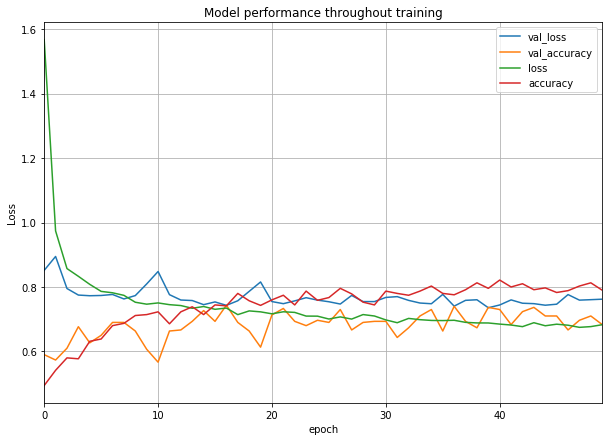

In [27]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [163]:
Y_predict = model.predict(X_val)

In [164]:
Y_predict

array([[0.22409044, 0.7649917 , 0.01091796],
       [0.6238154 , 0.32666418, 0.0495204 ],
       [0.30299354, 0.67190826, 0.02509821],
       [0.20310694, 0.77817   , 0.01872306],
       [0.7066844 , 0.26814768, 0.02516795],
       [0.5897753 , 0.38545552, 0.02476919],
       [0.22318846, 0.76027167, 0.01653989],
       [0.7133197 , 0.22468133, 0.06199896],
       [0.4728154 , 0.49959353, 0.02759108],
       [0.27676955, 0.70223993, 0.02099049],
       [0.61859226, 0.35464662, 0.02676107],
       [0.6071476 , 0.35618812, 0.03666435],
       [0.27651072, 0.70979404, 0.01369523],
       [0.5922474 , 0.38898233, 0.01877025],
       [0.27836108, 0.7009439 , 0.02069509],
       [0.5098402 , 0.46997988, 0.02017991],
       [0.5425411 , 0.41496405, 0.04249487],
       [0.07517581, 0.9160668 , 0.00875734],
       [0.60811657, 0.35700113, 0.03488234],
       [0.22516724, 0.7591197 , 0.01571304],
       [0.22182252, 0.76226056, 0.01591695],
       [0.2621958 , 0.72490054, 0.01290361],
       [0.

In [133]:
#Y_val = np.asarray(Y_val)

In [145]:
Y_val = pd.concat([Y_val_id, Y_val], axis=1)

In [147]:
Y_val['Class'] = Y_val.iloc[:,1:4].idxmax(axis = 1)

In [148]:
Y_val

,GalaxyID,Class1.1,Class1.2,Class1.3,Class
521,107555,0.000000,0.980000,0.020000,Class1.2
737,110923,0.437450,0.536271,0.026279,Class1.2
740,111022,0.371623,0.555417,0.072960,Class1.2
660,109629,0.284836,0.685696,0.029468,Class1.2
411,106018,0.698037,0.301963,0.000000,Class1.1
...,...,...,...,...,...
468,106885,0.305342,0.670223,0.024435,Class1.2
935,113987,0.147226,0.848798,0.003977,Class1.2
428,106230,0.646201,0.321552,0.032248,Class1.1
7,100128,0.687783,0.288344,0.023873,Class1.1


In [165]:
df = pd.DataFrame(Y_predict)
df

,0,1,2
0,0.224090,0.764992,0.010918
1,0.623815,0.326664,0.049520
2,0.302994,0.671908,0.025098
3,0.203107,0.778170,0.018723
4,0.706684,0.268148,0.025168
...,...,...,...
295,0.401200,0.573742,0.025058
296,0.228953,0.757530,0.013518
297,0.731297,0.238284,0.030420
298,0.630559,0.341859,0.027581


In [166]:
#Y_predict = pd.DataFrame(Y_predict, columns=('class1.1', 'class1.2', 'class1.3'))
Y_predict = pd.concat([Y_val_id, df], axis=1)


In [167]:
Y_predict

,GalaxyID,0,1,2
0,NaN,0.224090,0.764992,0.010918
1,NaN,0.623815,0.326664,0.049520
2,100053.0,0.302994,0.671908,0.025098
3,100078.0,0.203107,0.778170,0.018723
4,NaN,0.706684,0.268148,0.025168
...,...,...,...,...
989,114898.0,NaN,NaN,NaN
991,114965.0,NaN,NaN,NaN
994,115031.0,NaN,NaN,NaN
995,115033.0,NaN,NaN,NaN


In [ ]:
predict_ok = []
true = 0
false = 0
for i in range(len(Y_predict)):
    if Y_predict['Class'][i] == Y_val['Class'][i]:
        p = True 
        true += 1    
    else:
        p = False
        false += 1
    predict_ok.append(p)
                
predict_ok
print('Nombres de prédictions Valide :',true)
print('Nombres de mauvaise prédictions :',false)